In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
from fastai.vision import *
from fastai.metrics import error_rate
import pandas as pd
import numpy as np
import re

In [3]:
bs = 64

In [5]:
path = Path('data/Kaggle/Digit_Recognizer')
path.ls()

[PosixPath('data/Kaggle/Digit_Recognizer/train.csv'),
 PosixPath('data/Kaggle/Digit_Recognizer/test.csv')]

In [6]:
df_train = pd.read_csv(path/'train.csv')
df_train['fn'] = df_train.index
df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,fn
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4


In [7]:
class PixelImageItemList(ImageList):
    def open(self,fn):
        regex = re.compile(r'\d+')
        fn = re.findall(regex,fn)
        df = self.inner_df[self.inner_df.fn.values == int(fn[0])]
        df_fn = df[df.fn.values == int(fn[0])]
        img_pixel = df_fn.drop(labels=['label','fn'],axis=1).values
        img_pixel = img_pixel.reshape(28,28)
        img_pixel = np.stack((img_pixel,)*3,axis=-1)
        return vision.Image(pil2tensor(img_pixel,np.float32).div_(255))

In [8]:
src = (PixelImageItemList.from_df(df_train,path=path,cols='fn')
      .split_by_rand_pct(valid_pct = 0.2, seed = 42)
      .label_from_df(cols='label'))

In [10]:
tfms = get_transforms(max_rotate=10., max_zoom=1.05, do_flip=False)

In [12]:
data = (src.transform(tfms=tfms)
       .databunch(num_workers=2,bs=bs)
       .normalize(imagenet_stats))

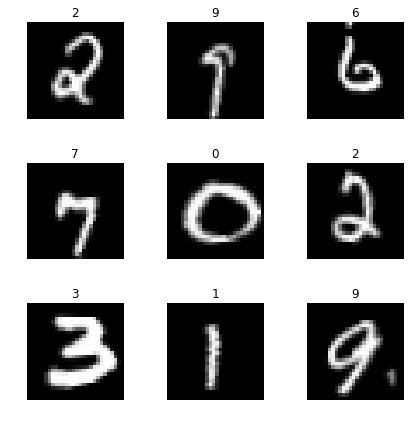

In [13]:
data.show_batch(rows=3, figsize=(6,6))

In [14]:
learn = cnn_learner(data,models.resnet50,metrics=accuracy)

In [15]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


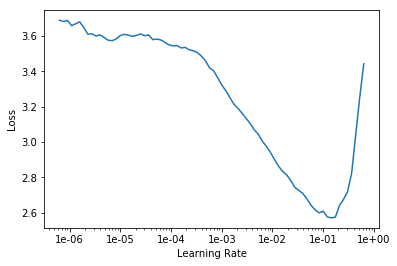

In [16]:
learn.recorder.plot()

In [17]:
learn.save('Pre-learn1')

In [18]:
learn.fit_one_cycle(5, max_lr=slice(1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,1.209595,0.951241,0.704286,00:50
1,0.719118,0.568748,0.813571,00:50
2,0.502672,0.391544,0.873214,00:52
3,0.397073,0.324330,0.895238,00:52
4,0.368883,0.308743,0.902857,00:51


In [20]:
learn.save('50-stage1')

In [21]:
learn.load('Pre-learn1')

Learner(data=ImageDataBunch;

Train: LabelList (33600 items)
x: PixelImageItemList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
1,1,4,0,7
Path: data/Kaggle/Digit_Recognizer;

Valid: LabelList (8400 items)
x: PixelImageItemList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
8,1,9,9,8
Path: data/Kaggle/Digit_Recognizer;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [22]:
learn.fit_one_cycle(5, max_lr=slice(1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.677568,0.453951,0.857857,00:52
1,0.243944,0.124809,0.961071,00:51
2,0.152765,0.074204,0.979167,00:51
3,0.102189,0.045098,0.985357,00:50
4,0.073134,0.041196,0.986905,00:50


In [23]:
learn.save('50-stage1')

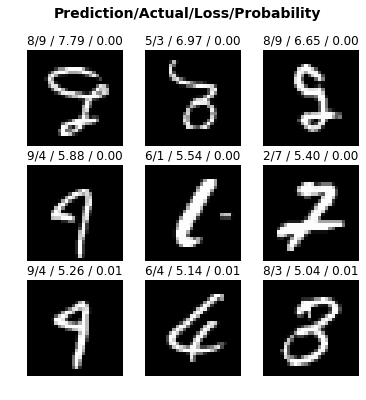

In [24]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9,figsize=(6,6))

In [25]:
learn.unfreeze()

In [26]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


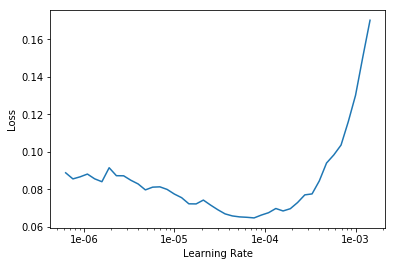

In [27]:
learn.recorder.plot()

In [28]:
learn.fit_one_cycle(7, max_lr=slice(3e-6,8e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.067662,0.040216,0.987738,00:50
1,0.062523,0.034520,0.988571,00:51
2,0.056693,0.032008,0.990119,00:50
3,0.050815,0.028070,0.991429,00:50
4,0.037276,0.023995,0.991548,00:50
5,0.031162,0.026771,0.991190,00:51
6,0.031124,0.023469,0.992381,00:50


In [29]:
learn.save('50-stage2')

In [30]:
learn.fit_one_cycle(3, max_lr=slice(3e-6,8e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.035878,0.027814,0.990952,00:50
1,0.031469,0.027283,0.991786,00:50
2,0.027081,0.024799,0.991667,00:51


In [31]:
learn.fit_one_cycle(5, max_lr=slice(3e-6,8e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.022328,0.027172,0.990952,00:51
1,0.037741,0.029438,0.991429,00:50
2,0.023933,0.022756,0.993452,00:50
3,0.017865,0.023003,0.993452,00:51
4,0.021509,0.023882,0.993214,00:51


In [32]:
learn.load('50-stage2')

Learner(data=ImageDataBunch;

Train: LabelList (33600 items)
x: PixelImageItemList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
1,1,4,0,7
Path: data/Kaggle/Digit_Recognizer;

Valid: LabelList (8400 items)
x: PixelImageItemList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
8,1,9,9,8
Path: data/Kaggle/Digit_Recognizer;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [33]:
learn.fit_one_cycle(6, max_lr=slice(3e-6,8e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.036450,0.024178,0.991786,01:05
1,0.030918,0.029417,0.991786,00:50
2,0.031114,0.025537,0.992143,00:50
3,0.024889,0.024594,0.992143,00:50
4,0.024255,0.021324,0.993095,00:50
5,0.019611,0.019907,0.993214,00:51


In [36]:
learn.save('50-stage3')

In [37]:
learn.fit_one_cycle(1, max_lr=slice(3e-6,8e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.027461,0.021607,0.993690,00:50


In [38]:
learn.save('50-stage4')

In [39]:
learn.fit_one_cycle(2, max_lr=slice(3e-6,8e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.032093,0.026869,0.992381,00:50
1,0.019658,0.024612,0.992262,00:51


In [40]:
learn.load('50-stage4')

Learner(data=ImageDataBunch;

Train: LabelList (33600 items)
x: PixelImageItemList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
1,1,4,0,7
Path: data/Kaggle/Digit_Recognizer;

Valid: LabelList (8400 items)
x: PixelImageItemList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
8,1,9,9,8
Path: data/Kaggle/Digit_Recognizer;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [41]:
learn.fit_one_cycle(3, max_lr=slice(3e-6,8e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.024593,0.025437,0.992381,00:50
1,0.017504,0.023527,0.992262,00:51
2,0.016745,0.021389,0.992976,00:53


In [42]:
learn.load('50-stage4')

Learner(data=ImageDataBunch;

Train: LabelList (33600 items)
x: PixelImageItemList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
1,1,4,0,7
Path: data/Kaggle/Digit_Recognizer;

Valid: LabelList (8400 items)
x: PixelImageItemList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
8,1,9,9,8
Path: data/Kaggle/Digit_Recognizer;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

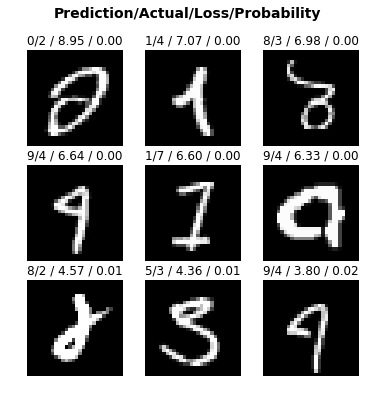

In [43]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9,figsize=(6,6))

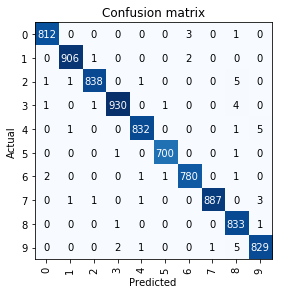

In [45]:
interp.plot_confusion_matrix()

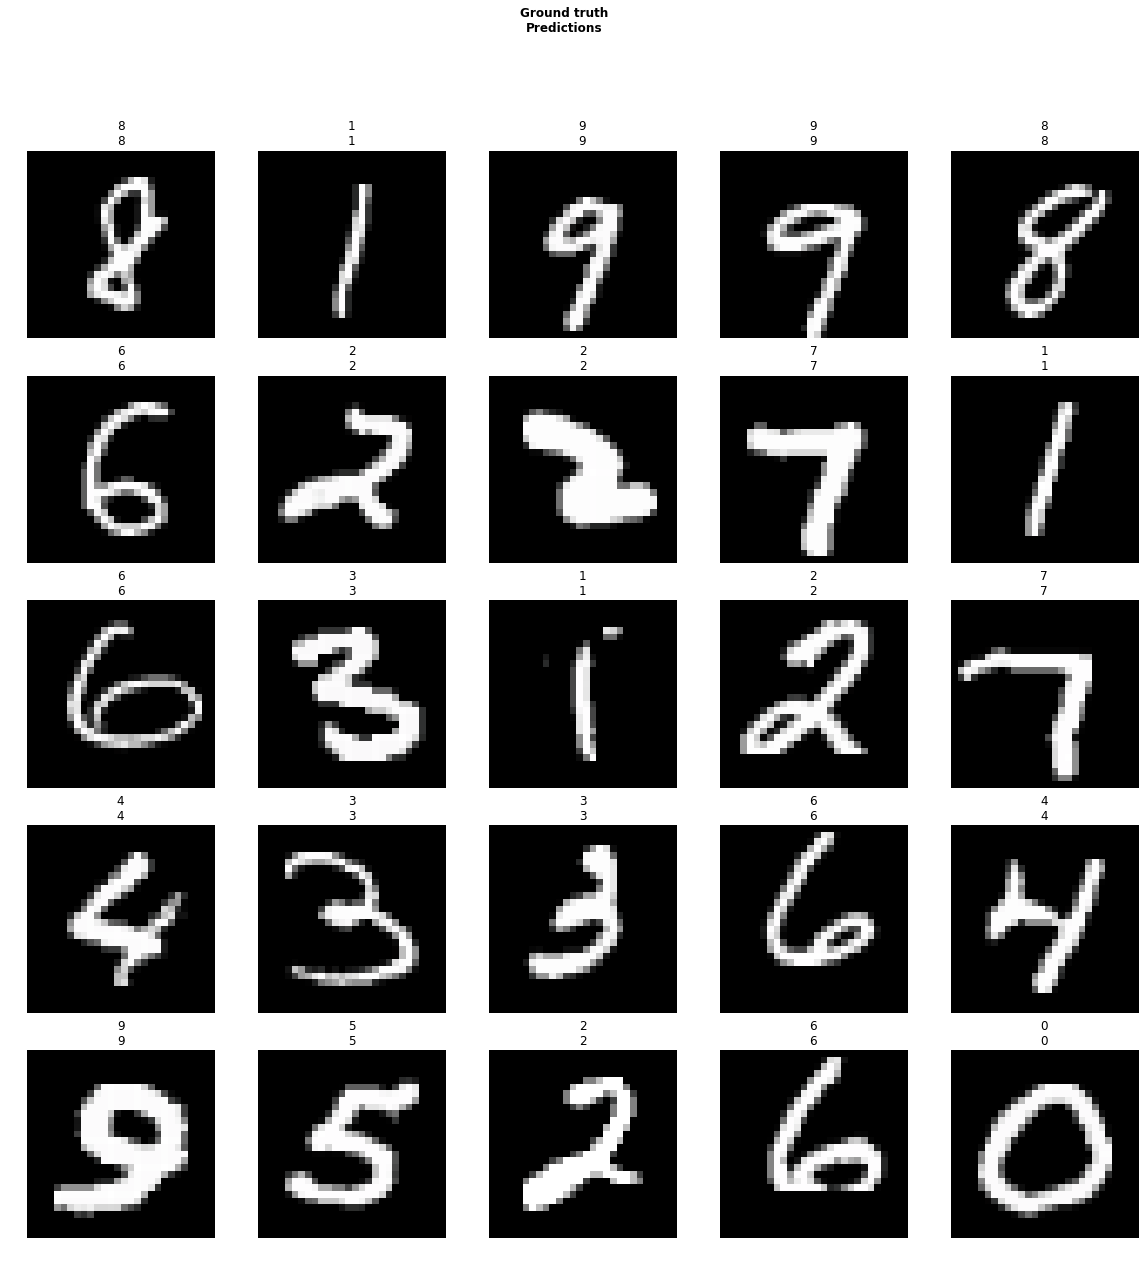

In [47]:
learn.show_results()

In [48]:
df_test = pd.read_csv(path/'test.csv')
df_test['label'] = 0
df_test['fn'] = df_test.index
df_test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,label,fn
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4


In [49]:
learn.data.add_test(PixelImageItemList.from_df(df_test,path=path,cols='fn'))

In [50]:
pred_test = learn.get_preds(ds_type=DatasetType.Test)

In [51]:
test_result = torch.argmax(pred_test[0],dim=1)
result = test_result.numpy()

In [55]:
test_result.shape

torch.Size([28000])

In [57]:
final = pd.Series(result,name='Label')
submission = pd.concat([pd.Series(range(1,28001),name='ImageId'),final],axis=1)
submission.to_csv('Kaggle-Digit_Recognizer-1.csv',index=False)

In [58]:
submission.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [59]:
learn.load('50-stage3')

Learner(data=ImageDataBunch;

Train: LabelList (33600 items)
x: PixelImageItemList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
1,1,4,0,7
Path: data/Kaggle/Digit_Recognizer;

Valid: LabelList (8400 items)
x: PixelImageItemList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
8,1,9,9,8
Path: data/Kaggle/Digit_Recognizer;

Test: LabelList (28000 items)
x: PixelImageItemList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: EmptyLabelList
,,,,
Path: data/Kaggle/Digit_Recognizer, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bo

In [60]:
learn.data.add_test(PixelImageItemList.from_df(df_test,path=path,cols='fn'))

In [61]:
pred_test1 = learn.get_preds(ds_type=DatasetType.Test)

In [62]:
test_result1 = torch.argmax(pred_test1[0],dim=1)
result1 = test_result1.numpy()

In [63]:
final1 = pd.Series(result1,name='Label')
submission1 = pd.concat([pd.Series(range(1,28001),name='ImageId'),final1],axis=1)
submission1.to_csv('Kaggle-Digit_Recognizer-2.csv',index=False)